# Lab 06 - Transformations

In this exercise, we will learn how to implement algorithms to find the best fir transformation model from a set of corresponding points.

## 6.0 Setup and Utilities Functions

First, make sure you have installed the required libraries and check what is your *present working directory*:

In [30]:
!pip install numpy matplotlib opencv-python
!echo "Your current directory is: $(pwd)"

Your current directory is: /content


You are provided with some utility functions for reading, writing, and rendering images.

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

def plot_points(x, xp):

  # Create the plot
  plt.figure(figsize=(12, 6))

  # Scatter plot for the first two columns
  plt.subplot(1, 2, 1)
  plt.scatter(x[:,0], x[:,1], 1, c='blue', alpha=1)
  plt.title('Scatter Plot of First Set')
  plt.xlabel('X-axis')
  plt.ylabel('Y-axis')
  plt.grid(True)

  # Scatter plot for the third and fourth columns
  plt.subplot(1, 2, 2)
  plt.scatter(xp[:,0], xp[:,1], 1, c='red', alpha=1)
  plt.title('Scatter Plot of Second Set')
  plt.xlabel('X-axis')
  plt.ylabel('Y-axis')
  plt.grid(True)

  # Show both plots
  plt.tight_layout()
  plt.show()

## 6.1 Fitting Affine Transformations

Suppose we have a set of 2D correspondences $(x_i,y_i)\leftrightarrow(x'_i,y'_i)$ for $1{\le}i{\le}N$. An actual set of points is in `points_case_1.npy` where each row of the matrix contains the data $(x_i,y_i,x'_i, y'_i)$ representing the correspondence.

Size of dataset1: (4558, 4)


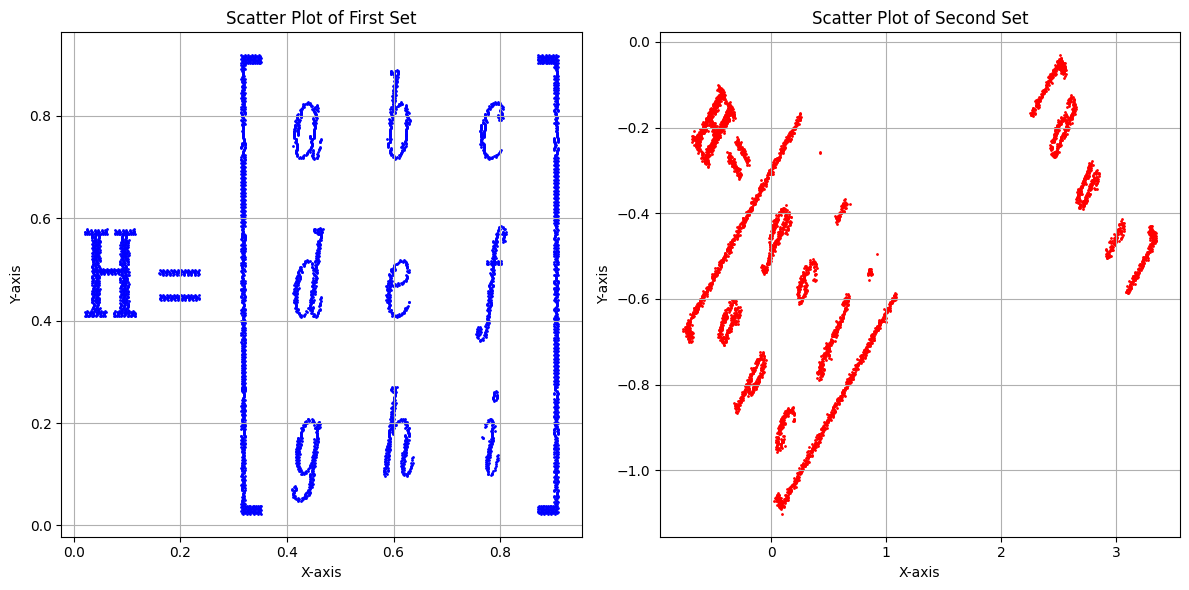

In [76]:
data1 = np.load("points_case_1.npy")

data1[-1000:, -2:] += [2.0, 0]

print(f"Size of dataset1: {data1.shape}")

# Extract x and y coordinates from the first two columns
x1 = data1[:, :2]  # First two columns

# Extract x' and y' coordinates from the third and fourth columns
xp1 = data1[:, -2:]  # Last two columns

plot_points(x1, xp1)

Fit a transformation of the form

$$
[x',y']^T=\textbf{S}[x,y]^T+\textbf{t}, \textbf{S}\in\mathbb{R}^{2\times2}, \textbf{t}\in\mathbb{R}^{2\times1}
$$

by setting up a problem of the form

$$
\underset{\textbf{v}\in\mathbb{R}^{6}}{\text{argmin}}||\textbf{Av}-\textbf{b}||^2_2
$$

and solving it via least-squares.

### Construct $\textbf{A}$

In [77]:
zv = np.zeros((x1.shape[0],1)) # vector of zeros
ov = np.ones((x1.shape[0],1))  # vector of ones

A_even = np.hstack((x1, zv, zv, ov, zv))
A_odd = np.hstack((zv, zv, x1, zv, ov))

# Construct A matrix
A = np.empty((2*x1.shape[0], 6))
A[0::2] = A_even
A[1::2] = A_odd

print(f"Size of A = {A.shape}")
print(f"First 2 rows of A =\n {A[:2,:]}")
print(f"First row of X =\n {x1[0,:]}")

Size of A = (9116, 6)
First 2 rows of A =
 [[0.314      0.91857143 0.         0.         1.         0.        ]
 [0.         0.         0.314      0.91857143 0.         1.        ]]
First row of X =
 [0.314      0.91857143]


### Construct $\textbf{b}$

In [78]:
# Construct b vector
bx = xp1[:,0].reshape(-1,1)
by = xp1[:,1].reshape(-1,1)

b = np.empty((2*xp1.shape[0], 1))
b[0::2] = bx
b[1::2] = by

print(f"Size of b = {b.shape}")
print(f"b =\n {b}")

Size of b = (9116, 1)
b =
 [[-0.76187091]
 [-0.67491226]
 [-0.74632645]
 ...
 [-0.45064245]
 [ 3.34408758]
 [-0.45312287]]


### Solving Least-Squares

In [79]:
v = np.linalg.lstsq(A, b)[0]

print(f"v = \n{v}")

S = np.array( [ [ v[0][0], v[1][0] ],
                [ v[2][0], v[3][0] ] ] )
print(f"S = \n{S}")

t = np.array( [ [ v[4][0] ],
                [ v[5][0] ] ] )
print(f"t = \n{t}")

v = 
[[ 1.85239253]
 [-3.94209417]
 [-0.70762108]
 [-0.70690933]
 [ 1.51022234]
 [ 0.20014656]]
S = 
[[ 1.85239253 -3.94209417]
 [-0.70762108 -0.70690933]]
t = 
[[1.51022234]
 [0.20014656]]


### Result

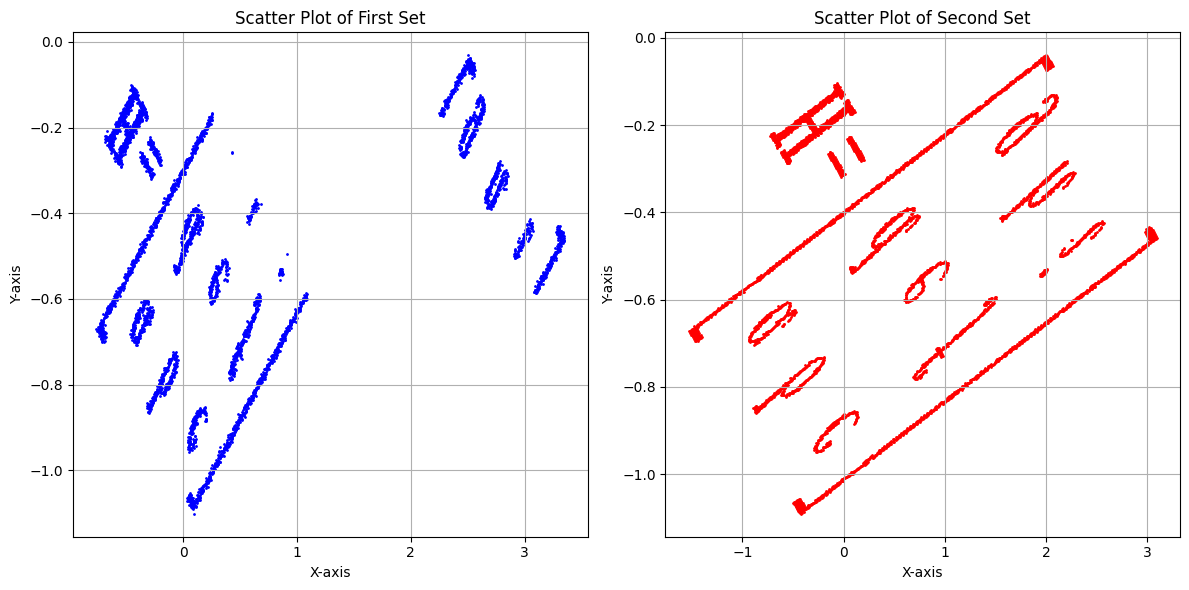

In [80]:
xh1 = np.matmul(S, x1.T) + t
plot_points(xp1, xh1.T)

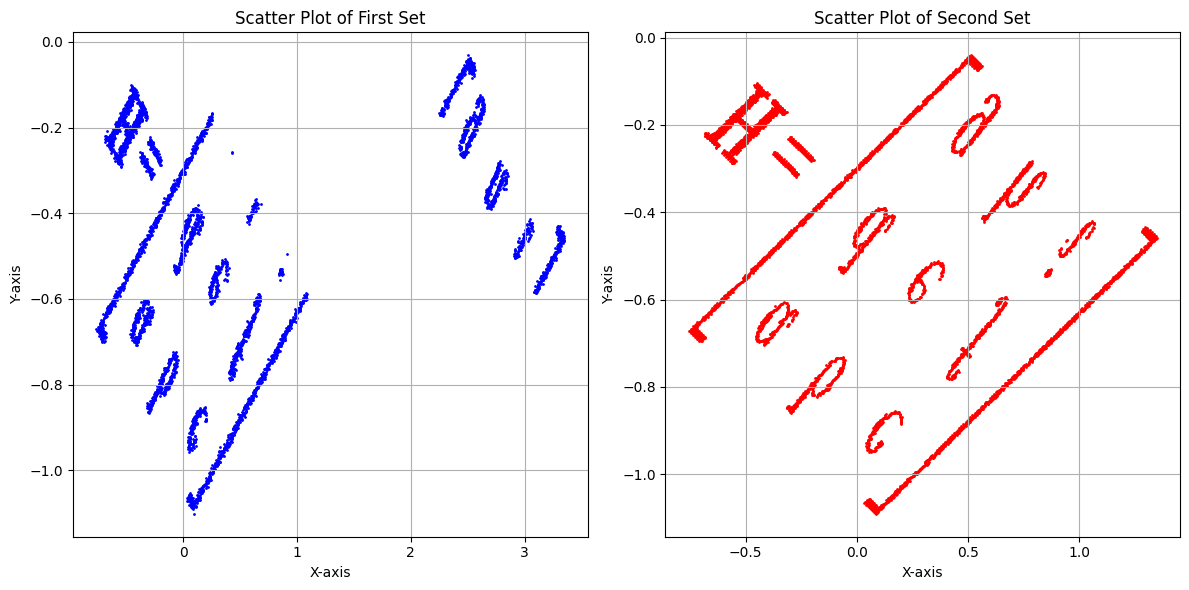

In [81]:
import random

def fit_affine(x, xp):
  zv = np.zeros((x.shape[0],1)) # vector of zeros
  ov = np.ones((x.shape[0],1))  # vector of ones

  A_even = np.hstack((x, zv, zv, ov, zv))
  A_odd = np.hstack((zv, zv, x, zv, ov))

  # Construct A matrix
  A = np.empty((2*x.shape[0], 6))
  A[0::2] = A_even
  A[1::2] = A_odd

  # Construct b vector
  bx = xp[:,0].reshape(-1,1)
  by = xp[:,1].reshape(-1,1)

  b = np.empty((2*xp.shape[0], 1))
  b[0::2] = bx
  b[1::2] = by

  v = np.linalg.lstsq(A, b)[0]

  S = np.array( [ [ v[0][0], v[1][0] ],
                  [ v[2][0], v[3][0] ] ] )

  t = np.array( [ [ v[4][0] ],
                  [ v[5][0] ] ] )

  return S, t



def RANSAC_fit_affine(x, xp, nIters=1000, threshold=1 ):
  bestNumInliers = 0
  bestInliers = None

  for _ in range(nIters):
    # 1. Randomly sample 3 correspondances
    sample_indices = random.sample(range(x.shape[0]), 3)
    sample_x = x[sample_indices]
    sample_xp = xp[sample_indices]

    # 2. Fit affine transformation
    S, t = fit_affine(sample_x, sample_xp)

    # 3. Find best fit model
    num_inliers = 0
    inliers = []
    for i in range(x.shape[0]):
      xph = np.matmul(S, x[i,:].T) + t

      # Compute the distance to the actual points
      err = np.linalg.norm(xp[i].T - xph)

      if err < threshold:
        num_inliers += 1
        inliers.append(i)

    # Update the best model if the current one has more inliers
    if num_inliers > bestNumInliers:
      bestNumInliers = num_inliers
      bestInliers = inliers

  return fit_affine(x[bestInliers], xp[bestInliers])

bestS, bestT = RANSAC_fit_affine(x1, xp1, nIters=100, threshold=0.2)

xh2 = np.matmul(bestS, x1.T) + bestT
plot_points(xp1, xh2.T)